#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from Comparative_Analysis import Alignment as alignfn
from random import sample
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
project_dir = 'F:/Project_Data/mabR_Project'
regulated_file = '2022-10-02_data.xlsx'
seq_dir = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_All_Levels/ncbi_dataset/data'
sequence_dirs = util.list_dirs(seq_dir)
tb_species = 'NC_000962.3' 
tb_annotation_dirname = 'GCF_000195955.2'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'
full_build = False

#### Create file with all CDS for species and - BLAST databases already created (see E-pump project)

In [3]:
def generate_protein_dataset(num_subsets, subset_num, dir_list): 
    sequence_dirs = util.chunk_list(dir_list, num_subsets, subset_num)
    all_cds = []
    all_tb_cds = []
    names = []
    sequences = []
    locations = []
    for dirname in (sequence_dirs):
        for genome_record in SeqIO.parse(seq_dir + '/' + dirname + '/genomic.gbff', "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            names.append([accession_ver, genome_record.annotations['organism']])
            full_sequence = str(genome_record.seq)
            sequences.append([accession_ver, full_sequence])
            for feature in genome_record.features:
                a = feature.qualifiers
                if feature.type == 'CDS' and a.get("translation") != None:
                    locus_tag = a.get("locus_tag")[0]
                    accession_locus = accession_ver + '@' + locus_tag
                    translation = a.get("translation")[0]
                    (start, stop, strand) = (int(feature.location.start), int(feature.location.end), int(feature.location.strand))
                    locations.append([accession_locus, (start, stop, strand)])
                    all_cds.append([accession_locus, translation])
                    if dirname == tb_annotation_dirname:
                        all_tb_cds.append([accession_locus, translation])
    return (all_cds, all_tb_cds, names, locations, sequences)           

In [4]:
#if full_build == True:
if 1==1:
    parallel_output = Parallel(n_jobs=-1)(delayed(generate_protein_dataset)(num_cores, core_number, sequence_dirs) for core_number in core_numbers)
    names_dict = {}
    locations_dict = {}
    sequence_dict = {}
    all_cds = []
    all_tb_cds = []
    for x in parallel_output:
        all_cds += x[0]
        all_tb_cds += x[1]
        for temp in x[2]:
            names_dict[temp[0]] = temp[1]
        for temp in x[3]:
            locations_dict[temp[0]] = temp[1]
        for temp in x[4]:
            sequence_dict[temp[0]] = temp[1]

In [5]:
with open(project_dir + '/names_dict.pkl', 'wb') as f:
        pickle.dump(names_dict, f) 

In [8]:
downreg_genes = pd.read_excel(project_dir + '/' + regulated_file, sheet_name = 'significnat genes downregulated')
upreg_genes = pd.read_excel(project_dir + '/' + regulated_file, sheet_name = 'significant genes upregulated')

In [9]:
downreg_genes

,Locus,Name,log2FoldChange,Fold change,padj,gene_set_m,gene_set_k,Comments,Unnamed: 8
0,NaN,Rv0859,-1.033287,NaN,2.716021e-03,NaN,NaN,NaN,NaN
1,Rv0024,Rv0024,-0.841414,NaN,6.135362e-03,"virulence, detoxification, adaptation",NaN,NaN,NaN
2,Rv0096,PPE1,-2.367367,NaN,2.768834e-08,PE/PPE,NaN,Isonitrile lipopeptide synthesis and copper ho...,NaN
3,Rv0097,Rv0097,-1.674485,NaN,1.655765e-03,intermediary metabolism and respiration,NaN,NaN,NaN
4,Rv0098,fcoT,-1.263189,NaN,9.373149e-03,lipid metabolism,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
93,Rv3772,hisC2,-0.493583,NaN,1.298495e-02,intermediary metabolism and respiration,00340 Histidine metabolism [PATH:mtu00340],NaN,NaN
94,Rv3774,echA21,-0.913978,NaN,1.729775e-03,lipid metabolism,00640 Propanoate metabolism [PATH:mtu00640],NaN,NaN
95,Rv3775,lipE,-1.395504,NaN,9.225201e-05,intermediary metabolism and respiration,NaN,NaN,https://pubmed.ncbi.nlm.nih.gov/31636137/
96,Rv3792,aftA,-0.895517,NaN,1.388483e-02,cell wall and cell processes,00572 Arabinogalactan biosynthesis - Mycobacte...,NaN,NaN


#### Subset based on loci of interest, and filter orthologues based on percent identity, synteny

In [22]:
loci = ['Rv0251c', 'Rv0252']    # [TetR,  divergent_gene]
target_loci = [tb_species + '@' + x for x in loci]

In [23]:
rbh = pd.read_csv(project_dir + '/reciprocal_best_hits.csv')
rbh = rbh[rbh['query_ref'].isin(target_loci)]
rbh['target_loc'] = rbh['target_ref'].map(locations_dict)
rbh['cds_count'] = rbh.groupby('target_species_name')['query_ref'].transform('size')
rbh['min_pct_id'] = rbh.groupby('target_species_name')['percent_identical_matches'].transform('min')

In [24]:
rbh = rbh[rbh['cds_count'] == 2]
for i, r in rbh.iterrows():
    (start, stop, strand) = r['target_loc']
    rbh.at[i,'start'] = start
    rbh.at[i,'stop'] =  stop
    rbh.at[i,'strand'] = strand
rbh['min_start'] = rbh.groupby('target_species_name')['start'].transform('min')
rbh['max_stop'] = rbh.groupby('target_species_name')['stop'].transform('max')
rbh['region_size'] = rbh['max_stop'] - rbh['min_start']
rbh = rbh[rbh['region_size'] < 5000]
rbh = rbh[rbh['min_pct_id'] >= 70]

In [25]:
rbh

,Unnamed: 0,query_ref,target_ref,query_length,subject_length,percent_identical_matches,alignment_length,number_mismatches,number_of_gap_openings,query_start_alignment,...,reciprocal_best_hit,target_loc,cds_count,min_pct_id,start,stop,strand,min_start,max_stop,region_size
37680,77611,NC_000962.3@Rv0251c,NZ_FXEG02000001.1@MAAFP003_RS02045,159,146,74.214,159,28,4,1,...,Y,"(446901, 447342, -1)",2,74.214,446901.0,447342.0,-1.0,446901.0,450135.0,3234.0
37681,77630,NC_000962.3@Rv0251c,NZ_MVHD01000043.1@BST11_RS20215,159,146,71.069,159,33,4,1,...,Y,"(25779, 26220, 1)",2,71.069,25779.0,26220.0,1.0,22971.0,26220.0,3249.0
37682,77592,NC_000962.3@Rv0251c,NZ_MVHE01000021.1@BST12_RS14690,159,149,72.956,159,33,3,1,...,Y,"(25429, 25879, -1)",2,72.956,25429.0,25879.0,-1.0,25429.0,28651.0,3222.0
37683,77628,NC_000962.3@Rv0251c,NZ_MVHG01000044.1@BST14_RS16935,159,146,73.585,159,29,4,1,...,Y,"(24926, 25367, 1)",2,73.585,24926.0,25367.0,1.0,22116.0,25367.0,3251.0
37684,77613,NC_000962.3@Rv0251c,NZ_MVHI01000046.1@BST16_RS23585,159,145,74.843,159,26,5,1,...,Y,"(24778, 25216, -1)",2,74.843,24778.0,25216.0,-1.0,24778.0,27978.0,3200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37920,77797,NC_000962.3@Rv0252,NZ_LT717700.1@MTAB308_RS14285,853,857,89.461,854,86,3,1,...,Y,"(1269670, 1272244, -1)",2,76.101,1269670.0,1272244.0,-1.0,1269670.0,1272910.0,3240.0
37921,77795,NC_000962.3@Rv0252,NZ_MVIL01000019.1@BST46_RS08170,853,855,88.525,854,95,2,1,...,Y,"(39096, 41664, 1)",2,71.069,39096.0,41664.0,1.0,38428.0,41664.0,3236.0
37922,77803,NC_000962.3@Rv0252,NZ_LQPY01000011.1@AWC29_RS05095,853,854,88.421,855,96,2,1,...,Y,"(340133, 342698, 1)",2,75.472,340133.0,342698.0,1.0,339467.0,342698.0,3231.0
37923,77769,NC_000962.3@Rv0252,NC_000962.3@Rv0252,853,853,100.000,853,0,0,1,...,Y,"(302865, 305427, 1)",2,100.000,302865.0,305427.0,1.0,302172.0,305427.0,3255.0


#### Generate FASTA file containing intergenic regions in orthologous species and run Muscle

In [17]:
intergenic_regions = []
tetR_regions = []
for target_species in list(rbh['target_species_name'].unique()):
    temp = rbh[rbh['target_species_name'] == target_species]
    for i, r in temp.iterrows():
        target_species_accession = r['target_species']
        if r['query_ref'].split('@')[1] == loci[1]:
            divgene_coords = r['target_loc']
        if r['query_ref'].split('@')[1] == loci[0]:
            tetR_coords = r['target_loc']
    if divgene_coords[2] == 1:
        intergenic_region = (tetR_coords[1], divgene_coords[0]+3, 1)
    else:
        intergenic_region = (divgene_coords[1] - 3, tetR_coords[0], -1)
    if intergenic_region[2] == 1:
        intergenic_sequence = sequence_dict[target_species_accession][intergenic_region[0]: intergenic_region[1]]
    else:
        intergenic_sequence = util.reverse_complement(sequence_dict[target_species_accession][intergenic_region[0]: intergenic_region[1]])
    intergenic_regions.append([target_species.replace(" ", "_"), intergenic_sequence])
    
    if tetR_coords[2]==1:    
        tetR_sequence = sequence_dict[target_species_accession][tetR_coords[0]: tetR_coords[1]]
    else:
        tetR_sequence = util.reverse_complement(sequence_dict[target_species_accession][tetR_coords[0]: tetR_coords[1]]) 
    tetR_regions.append([target_species.replace(" ", "_"), tetR_sequence])
    
util.produce_fasta_file(intergenic_regions, project_dir +'/intergenic_regions.fasta')
cline = MuscleCommandline(muscle_exe, input= project_dir +'/intergenic_regions.fasta', out=project_dir + '/intergenic_region_'+loci[0]+'_'+loci[1] + '_alignment.fasta')
result = cline();

100%|██████████| 28/28 [00:00<00:00, 59433.46it/s]


In [ ]:
blastfn.run_rscape(project_dir, 'intergenic_region_alignment3.sto', 'rscape_output')

#### Produce full ortholog file for phylogenetic tree

In [9]:
cds_dict = {}
for (x, y) in tqdm(all_cds):
    cds_dict[x] = y

100%|██████████| 1116061/1116061 [00:00<00:00, 2371354.64it/s]


In [10]:
rbh = pd.read_csv(project_dir + '/reciprocal_best_hits.csv')

In [11]:
query_refs = list(rbh['query_ref'].unique())

In [12]:
full_ortholog_refs = []
for ref in tqdm(query_refs):
    temp = rbh[rbh['query_ref'] == ref]
    if len(temp) == len(set(names_dict.values())):
        full_ortholog_refs.append(ref)

100%|██████████| 3896/3896 [01:07<00:00, 57.33it/s]


In [13]:
len(full_ortholog_refs)

325

In [ ]:
concatenated_alignment_dict = {}
for ref in tqdm(full_ortholog_refs):
    temp_seq = []
    temp = rbh[rbh['query_ref'] == ref]
    for i, r in temp.iterrows():
        temp_seq.append([r['target_species_name'].replace(' ','_'),cds_dict[r['target_ref']]])
    util.produce_fasta_file(temp_seq, project_dir +'/temp_seq.fasta')    
    cline = MuscleCommandline(muscle_exe, input= project_dir +'/temp_seq.fasta', out=project_dir +'/temp_seq_alignment.fasta')
    result = cline();    
    alignment = util.read_fasta_to_array(project_dir +'/temp_seq_alignment.fasta')    
    for (name, sequence) in zip(alignment[0], alignment[1]):
        if name in concatenated_alignment_dict:
            temp2 = concatenated_alignment_dict[name]
            concatenated_alignment_dict[name] = temp2 + sequence
        else:
            concatenated_alignment_dict[name] = sequence
temp  = []
for k, v in concatenated_alignment_dict.items():
    temp.append([k, v])
util.produce_fasta_file(temp, project_dir + '/concatenated_alignment.fasta')

In [45]:
if full_run == True:
    subprocess.run('cd c:\\users\\nicho\\IQTree & bin\\iqtree2 -s ' +  'concatenated_alignment.fasta' + ' --prefix Concatenated_Mycobacteria_Tree -m JTT -B 1000 -T AUTO ', shell=True)
   

CompletedProcess(args='cd c:\\users\\nicho\\IQTree & bin\\iqtree2 -s concatenated_alignment.fasta --prefix Concatenated_Mycobacteria_Tree -m JTT -B 1000 -T AUTO ', returncode=0)

In [58]:
i=0
dist_names = []
distances = []
with open(project_dir + '/Concatenated_Mycobacteria_Tree.mldist','r') as ofile: 
    sequence_names = []
    sequence_list = []
    first_seq = 0
    for l in ofile:
        m = l.strip('\n')
        if i > 0:
            dist_names.append(m.split(' ')[0])
            if 'tuberculosis' in m.split(' ')[0]:
                temp= (m.split(' ')[1:])
                for x in temp:
                    if len(x) > 0:
                        distances.append(float(x))
        i+=1
dist_dict = {}
for (name, dist) in zip(dist_names, distances):
    dist_dict[name] = dist


In [76]:
# initialize list of lists
data = []
n= 0
# Create the pandas DataFrame
for ref in tqdm(full_ortholog_refs):
    temp_seq = []
    temp = rbh[rbh['query_ref'] == ref]
    for i, r in temp.iterrows():
        if r['target_species_name'].replace(' ','_') in dist_dict:
            data.append([n, dist_dict[r['target_species_name'].replace(' ','_')], r['bit_score']])
    n+=1
    if n>50:
        break    
df = pd.DataFrame(data, columns = ['gene','dist', 'bit_score'])

 15%|█▌        | 50/325 [00:01<00:06, 41.42it/s]


<AxesSubplot:xlabel='dist', ylabel='bit_score'>

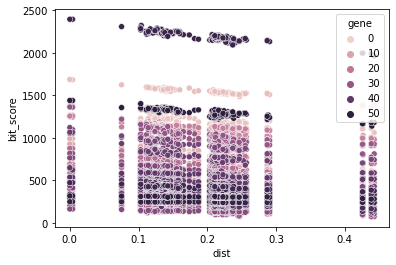

In [77]:
sns.scatterplot(data = df, x = 'dist', y = 'bit_score', hue = 'gene')

In [83]:
ortholog_20_refs = []
for ref in tqdm(query_refs):
    temp = rbh[rbh['query_ref'] == ref]
    if len(temp) > 60 and len(temp) < 100:
        ortholog_20_refs.append(ref)

100%|██████████| 3896/3896 [01:06<00:00, 58.15it/s]


In [84]:
len(ortholog_20_refs)

251

  2%|▏         | 5/251 [00:00<00:06, 39.48it/s]


<AxesSubplot:xlabel='dist', ylabel='bit_score'>

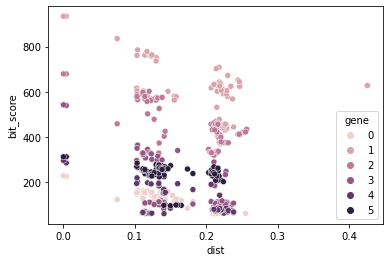

In [85]:
# initialize list of lists
data = []
n= 0
# Create the pandas DataFrame
for ref in tqdm(ortholog_20_refs):
    temp_seq = []
    temp = rbh[rbh['query_ref'] == ref]
    for i, r in temp.iterrows():
        if r['target_species_name'].replace(' ','_') in dist_dict:
            data.append([n, dist_dict[r['target_species_name'].replace(' ','_')], r['bit_score']])
    n+=1
    if n>5:
        break    
df = pd.DataFrame(data, columns = ['gene','dist', 'bit_score'])
sns.scatterplot(data = df, x = 'dist', y = 'bit_score', hue = 'gene')

In [135]:
highly_conserved_orthologs = []
highly_conserved_refs = ['Rv2817c']
for ref in highly_conserved_refs:
    temp = rbh[rbh['query_ref'] == 'NC_000962.3@'+ref]
    highly_conserved_orthologs.append(ref)

100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


<AxesSubplot:xlabel='dist', ylabel='bit_score'>

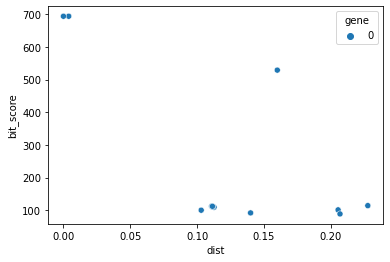

In [136]:
data = []
n= 0
# Create the pandas DataFrame
for ref in tqdm(highly_conserved_orthologs):
    temp_seq = []
    temp = rbh[rbh['query_ref'] == 'NC_000962.3@'+ref]
    for i, r in temp.iterrows():
        if r['target_species_name'].replace(' ','_') in dist_dict:
            data.append([n, dist_dict[r['target_species_name'].replace(' ','_')], r['bit_score']])
    n+=1
    if n>5:
        break    
df = pd.DataFrame(data, columns = ['gene','dist', 'bit_score'])
sns.scatterplot(data = df, x = 'dist', y = 'bit_score', hue = 'gene')

In [87]:
rbh_morf = pd.read_csv('F:/Project_Data/Project_10/rbh_non_overlap_morf.csv')

In [115]:
ortholog_20_refs

['NC_000962.3@Rv0025',
 'NC_000962.3@Rv0069c',
 'NC_000962.3@Rv0072',
 'NC_000962.3@Rv0079',
 'NC_000962.3@Rv0080',
 'NC_000962.3@Rv0082',
 'NC_000962.3@Rv0083',
 'NC_000962.3@Rv0084',
 'NC_000962.3@Rv0085',
 'NC_000962.3@Rv0086',
 'NC_000962.3@Rv0087',
 'NC_000962.3@Rv0093c',
 'NC_000962.3@Rv0096',
 'NC_000962.3@Rv0097',
 'NC_000962.3@Rv0098',
 'NC_000962.3@Rv0099',
 'NC_000962.3@Rv0100',
 'NC_000962.3@Rv0107c',
 'NC_000962.3@Rv0108c',
 'NC_000962.3@Rv0118c',
 'NC_000962.3@Rv0119',
 'NC_000962.3@Rv0132c',
 'NC_000962.3@Rv0157A',
 'NC_000962.3@Rv0180c',
 'NC_000962.3@Rv0188',
 'NC_000962.3@Rv0219',
 'NC_000962.3@Rv0256c',
 'NC_000962.3@Rv0258c',
 'NC_000962.3@Rv0280',
 'NC_000962.3@Rv0362',
 'NC_000962.3@Rv0366c',
 'NC_000962.3@Rv0367c',
 'NC_000962.3@Rv0368c',
 'NC_000962.3@Rv0370c',
 'NC_000962.3@Rv0372c',
 'NC_000962.3@Rv0377',
 'NC_000962.3@Rv0392c',
 'NC_000962.3@Rv0398c',
 'NC_000962.3@Rv0399c',
 'NC_000962.3@Rv0403c',
 'NC_000962.3@Rv0420c',
 'NC_000962.3@Rv0442c',
 'NC_000962.3

In [89]:
morf_query_refs = list(rbh_morf['query_accession_ver'].unique())

In [110]:
morf_refs = []
for ref in tqdm(morf_query_refs):
    temp = rbh_morf[rbh_morf['query_accession_ver'] == ref]
    if len(temp) ==12:
        morf_refs.append(ref)

100%|██████████| 3452/3452 [00:01<00:00, 1897.99it/s]


In [111]:
len(morf_refs)

17

In [112]:
data = []
n= 0
# Create the pandas DataFrame
for ref in tqdm(morf_refs):
    temp_seq = []
    temp = rbh_morf[rbh_morf['query_accession_ver'] == ref]
    for i, r in temp.iterrows():
        if r['subject_species_name'].replace(' ','_') in dist_dict:
            data.append([ref, dist_dict[r['subject_species_name'].replace(' ','_')], r['bit_score']])
    n+=1
df = pd.DataFrame(data, columns = ['orf_ref','dist', 'bit_score'])

100%|██████████| 17/17 [00:00<00:00, 848.49it/s]


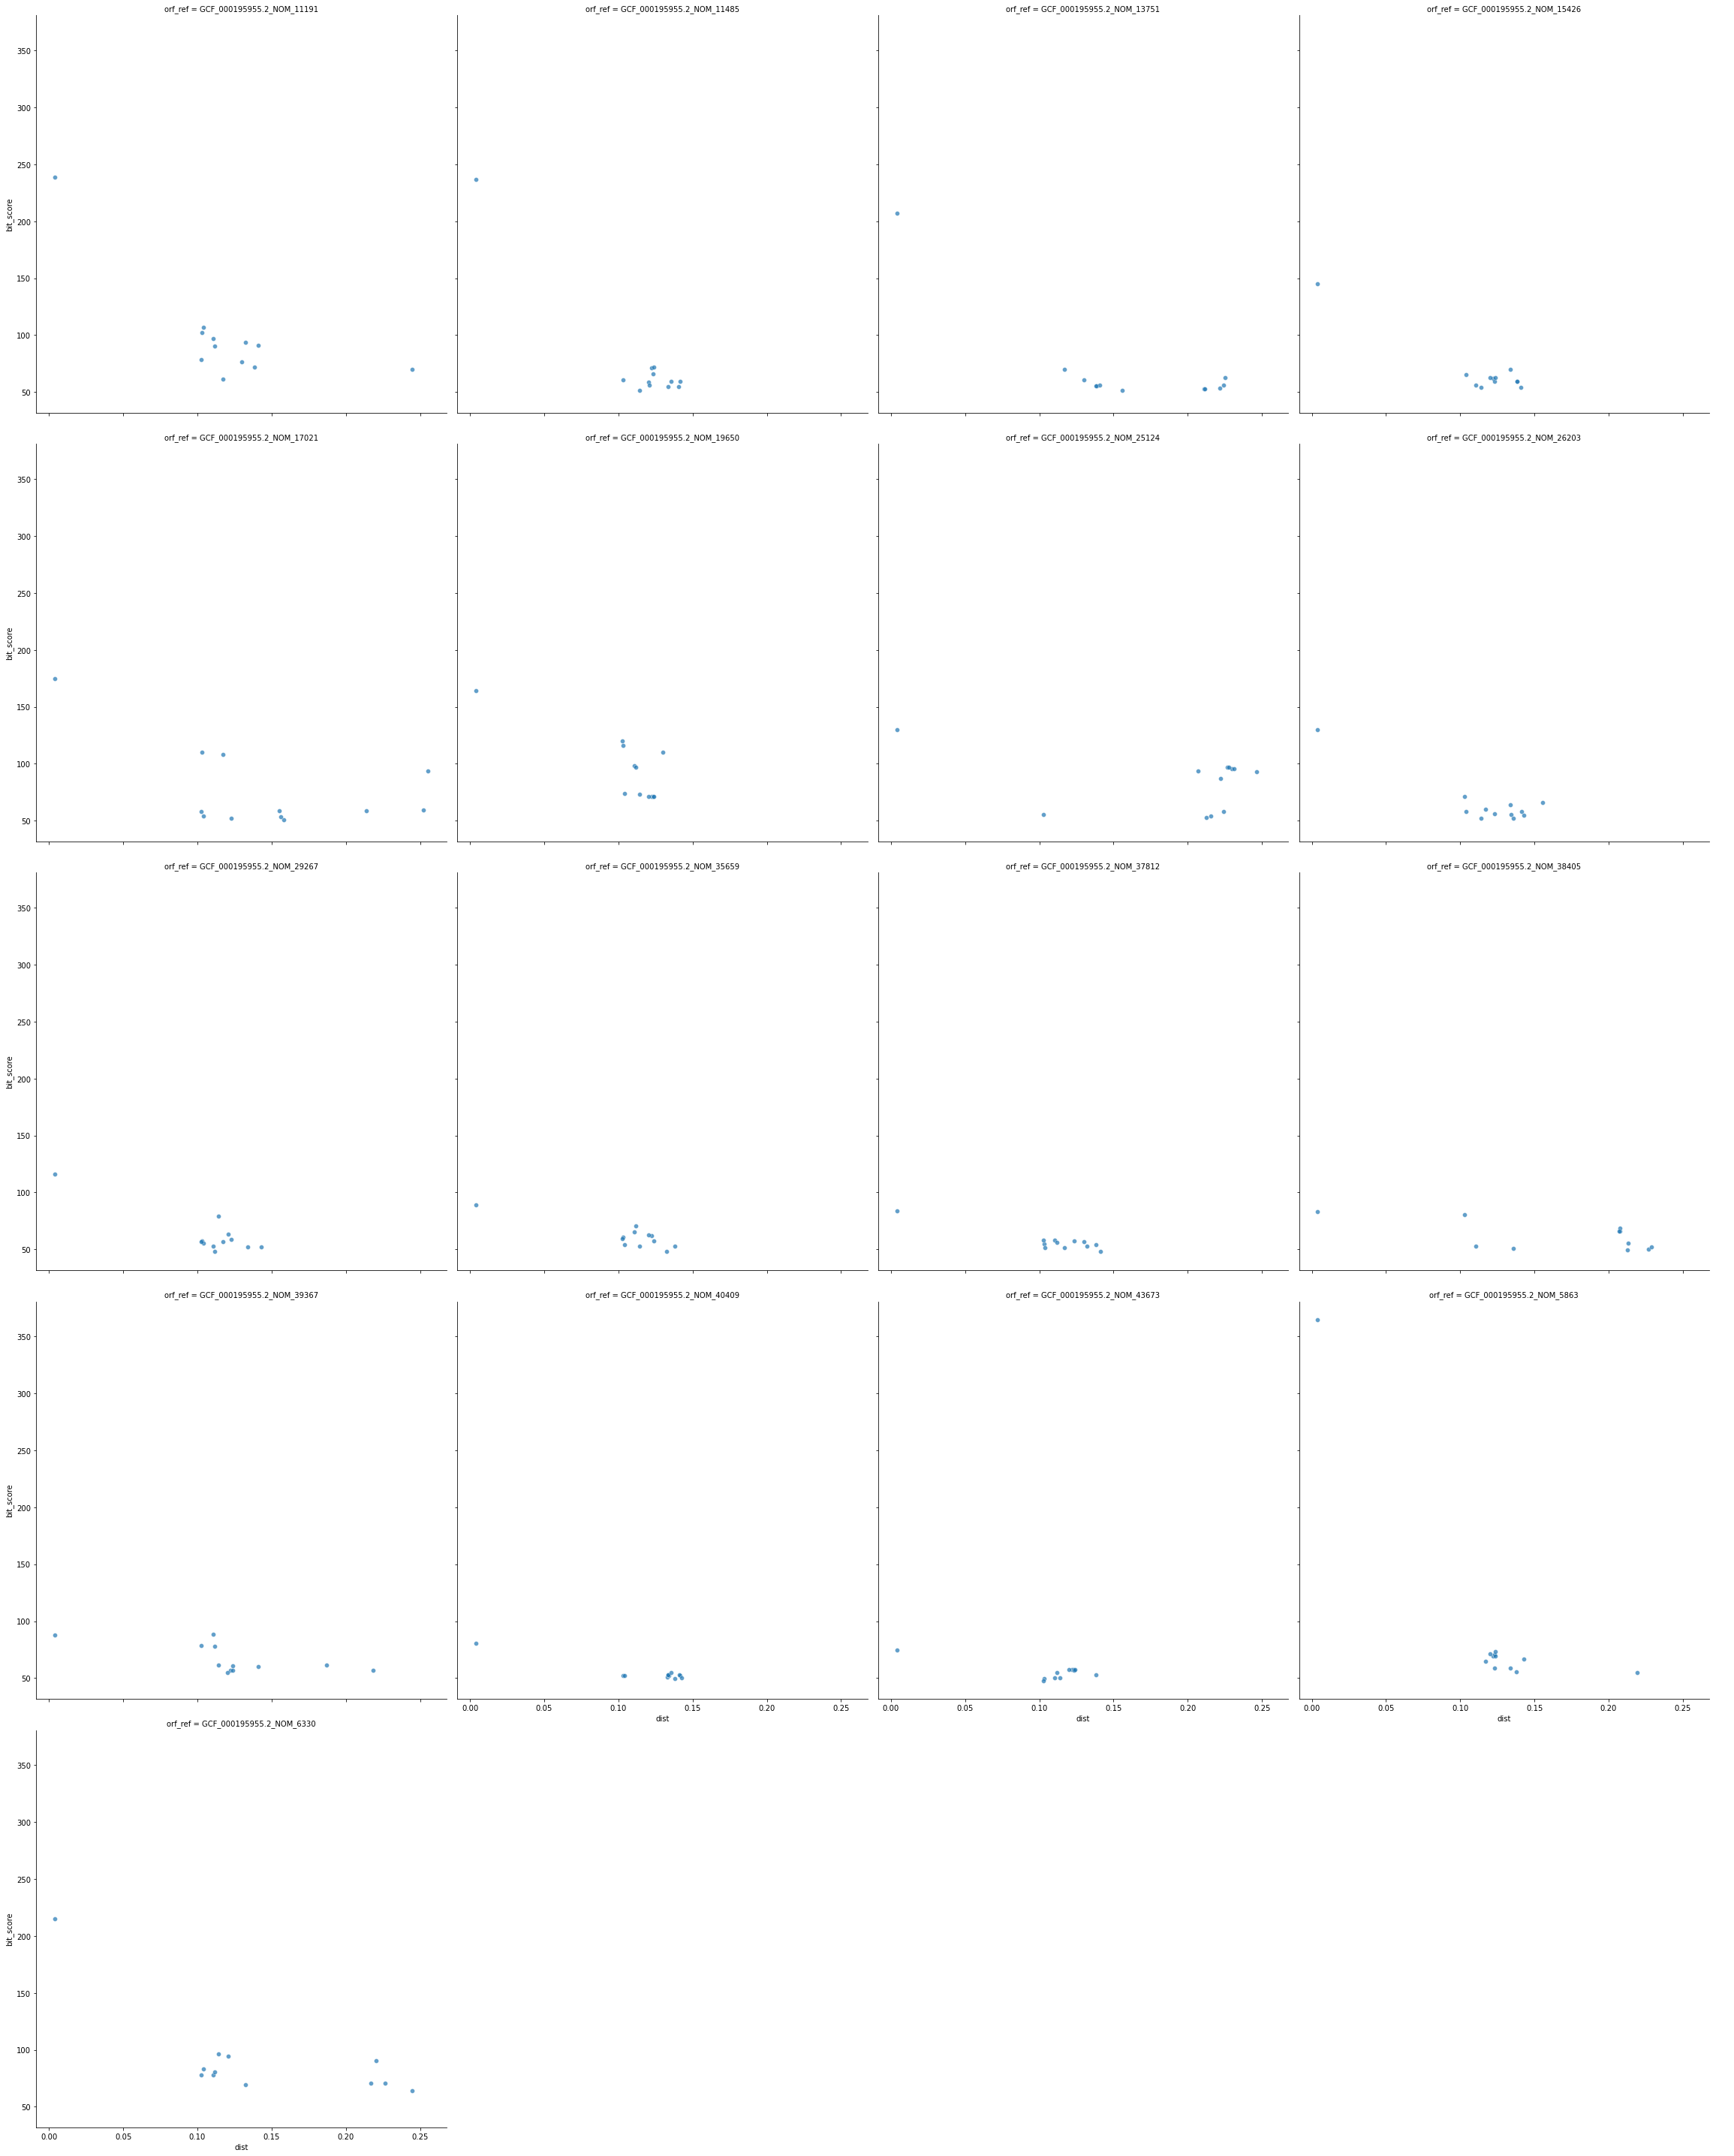

In [113]:
g = sns.FacetGrid(df, col='orf_ref', col_wrap=4, height=8)
g.map(sns.scatterplot, 'dist', 'bit_score', alpha=.7)
g.add_legend()
#sns.scatterplot(data = df, x = 'dist', y = 'bit_score', hue = 'gene')